**Calibration of the age-stratified deterministic model**

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

# Load required packages

In [18]:
import random
import os
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
from datetime import datetime, timedelta
import datetime
import scipy
from scipy.integrate import odeint
from scipy.stats import norm
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st

import math
import xarray as xr
import emcee
import json
import corner

from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot
from covid19model.optimization.run_optimization import full_calibration_wave1, full_calibration_wave2
from covid19model.models.utils import draw_sample_COVID19_SEIRD, ramp_fun, lockdown_func, policies_until_september


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# import dask

# from dask.distributed import Client, progress
# client = Client(threads_per_worker=16, n_workers=1)
# client

# Get public data

In [3]:
#df_sciensano = sciensano.get_sciensano_COVID19_data(update=True)


In [4]:
raw_hosp_data = pd.read_csv('../data/raw/sciensano/COVID19BE_HOSP.csv', parse_dates=['DATE'])
Hainaut_hosp_data = raw_hosp_data[raw_hosp_data.PROVINCE=='Hainaut']
Hainaut_ts = Hainaut_hosp_data[['DATE','NEW_IN']].set_index('DATE')
timeseries = Hainaut_ts['NEW_IN']

In [5]:
# fig,ax = plt.subplots()
# Hainaut_ts.reset_index().plot('DATE','NEW_IN', logy=True, ax=ax)
# ax.set_xlim('2020-08-01', '2020-11-05')

# Load data

In [6]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
# Define the number of age categories
levels = initN.size
province_names = pd.read_csv('../data/raw/GIS/NIS_province.csv')
initN_province = pd.read_csv('../data/interim/demographic/initN_province.csv')
initN = np.array(list(initN_province.set_index('NIS').loc[50000].iloc[:9]))

In [7]:
fig_path = '../results/calibrations_provinces/'
samples_path = '../data/interim/model_parameters/provinces/'

# Model initialisations

In [8]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params_wave1 = model_parameters.get_COVID19_SEIRD_parameters()
params_wave1.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date': pd.to_datetime('2020-03-15')})
# Usage:
initial_states = {'S': initN, 'E': np.ones(levels)}
model_wave1 = models.COVID19_SEIRD(initial_states, params_wave1, time_dependent_parameters={'Nc': lockdown_func})

In [9]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params_until_sept = model_parameters.get_COVID19_SEIRD_parameters()

params_until_sept.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy2': 1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure,
              'policy3': 1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure,
              'policy4': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure,
              'policy5': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.15)*Nc_others + (1-0.85)*Nc_schools + (1-0.50)*Nc_leisure,
              'policy6': 1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.10)*Nc_others + (1-0.35)*Nc_schools + (1-0.30)*Nc_leisure,
              'policy7': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.25)*Nc_transport + (1-0.05)*Nc_others + (1-0.30)*Nc_leisure,
              'policy8': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.35)*Nc_transport + (1-0.15)*Nc_others + (1-0.40)*Nc_leisure,
              'policy9': 1.0*Nc_home + (1-0.00)*Nc_work + (1-0.00)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_schools + (1-0.00)*Nc_leisure,
              'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date':pd.to_datetime('2020-03-15')})

# Usage:
initial_states = {'S': initN, 'E': np.ones(levels)}
model_wave1_with_policies = models.COVID19_SEIRD(initial_states, params_until_sept, time_dependent_parameters={'Nc': policies_until_september})

# Plotfunctions

In [68]:
def plot_simulations(start_date, end_ramp, end_date, model, samples_dict, timeseries, 
                    spatial_unit, n_lines=200, save=False):

    states = [['H_in']]
    data=[timeseries[start_date:end_ramp].values]

    fig,ax=plt.subplots()
    for i in range(n_lines):
        idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
        if 'l' in model.parameter_names:
            idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
            model.parameters['tau'] = samples_dict['tau'][idx]
            model.parameters['prevention'] = samples_dict['prevention'][idx]
        y_model = model.sim(time=end_date, excess_time=samples_dict['warmup'], start_date=start_date)
        ax = plot_fit(y_model,data,start_date,samples_dict['warmup'],states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
    
    # plot mean line
    model.parameters['beta'] = np.mean(samples_dict['beta'])
    if 'l' in model.parameter_names:
        model.parameters['l'] = np.mean(samples_dict['l'])
        model.parameters['tau'] = np.mean(samples_dict['tau'])
        model.parameters['prevention'] = np.mean(samples_dict['prevention'])
    y_model = model.sim(time=end_date, excess_time=samples_dict['warmup'], start_date=start_date)
    ax.plot(y_model['time'],y_model['H_in'].sum(dim='Nc'), c='green', linestyle='--', lw=2, alpha=0.5)
    
    data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
    plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
    legend_text=['daily \nhospitalizations']
    ax.set_xlim(start_date, end_date)
    fig.tight_layout()
    if save==True:
        fig.savefig(fig_path+spatial_unit +'_'+str(datetime.date.today())+'.pdf',bbox_inches='tight', dpi=600)
    return

# Calibration on first wave

In [11]:
## First wave
start_date = '2020-03-15'
end_beta = '2020-03-25'
end_ramp = '2020-05-23'#'2020-05-23'

In [12]:
len(Hainaut_ts.loc[start_date:end_beta])

11

In [13]:
len(Hainaut_ts.loc[end_beta:end_ramp])

60

In [ ]:
spatial_unit = 'Hainaut_wave1'
samples_dict = full_calibration_wave1(model_wave1, timeseries, spatial_unit, start_date, end_beta, end_ramp, 
                                fig_path=fig_path, samples_path=samples_path,
                                initN=initN, Nc_total=Nc_total,
                                maxiter=100, popsize=200, steps_mcmc=1000)

100%|██████████| 1000/1000 [07:04<00:00,  2.36it/s]


Calibrating beta. Warning: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
No constraints given.
[[5.10596683e+01 1.28145264e+01 1.43755485e+01 7.17308158e-01]
 [1.51365668e+00 1.91394553e+01 4.86833916e+00 8.73517143e-01]
 [8.69071666e+01 2.04188354e+00 8.20592894e+00 7.29809594e-01]
 [6.27264195e+01 1.31608608e+01 1.19329840e+01 5.86897800e-02]
 [5.72603034e+01 1.78563231e+01 1.00817046e+01 5.83462627e-01]
 [8.56488322e+00 1.63948994e+01 8.40362656e+00 2.42631025e-01]
 [8.18438686e+01 6.38363722e+00 2.90732002e+00 4.98498072e-01]
 [6.44789796e+01 1.89604833e+01 3.89486610e+00 6.68396721e-01]
 [8.82682097e+01 4.51940436e+00 1.79011884e+01 1.31981619e-01]
 [5.41945814e+01 2.46199330e+00 1.41117521e+01 2.71720082e-01]
 [3.93045910e+01 1.78303887e+01 4.30983350e+00 4.73696774e-01]
 [7.34548686e+01 1.67553932e+01 9.07917527e+00 5.14280727e-01]
 [8.02209796e+01 1.82951562e+01 1.89461942e+01 2.

Best after iteration 1: [29.90007656 17.34774698 16.80211595  0.10798645] 281.6361072101866
New best for swarm at iteration 2: [34.18451892 20.         18.61920334  0.        ] 279.9719220324474
Best after iteration 2: [34.18451892 20.         18.61920334  0.        ] 279.9719220324474
Best after iteration 3: [34.18451892 20.         18.61920334  0.        ] 279.9719220324474
Best after iteration 4: [34.18451892 20.         18.61920334  0.        ] 279.9719220324474
New best for swarm at iteration 5: [33.46940492 20.         17.54858991  0.        ] 279.18973484694425
Best after iteration 5: [33.46940492 20.         17.54858991  0.        ] 279.18973484694425
Best after iteration 6: [33.46940492 20.         17.54858991  0.        ] 279.18973484694425
Best after iteration 7: [33.46940492 20.         17.54858991  0.        ] 279.18973484694425
Best after iteration 8: [33.46940492 20.         17.54858991  0.        ] 279.18973484694425
Best after iteration 9: [33.46940492 20.         17.5

Best after iteration 80: [32.88187633 20.         17.00098779  0.        ] 278.898329707788
Best after iteration 81: [32.88187633 20.         17.00098779  0.        ] 278.898329707788
Best after iteration 82: [32.88187633 20.         17.00098779  0.        ] 278.898329707788
Best after iteration 83: [32.88187633 20.         17.00098779  0.        ] 278.898329707788
Best after iteration 84: [32.88187633 20.         17.00098779  0.        ] 278.898329707788
Best after iteration 85: [32.88187633 20.         17.00098779  0.        ] 278.898329707788
Best after iteration 86: [32.88187633 20.         17.00098779  0.        ] 278.898329707788
New best for swarm at iteration 87: [32.87738196 20.         17.00194073  0.        ] 278.82628810429514
Best after iteration 87: [32.87738196 20.         17.00194073  0.        ] 278.82628810429514
Best after iteration 88: [32.87738196 20.         17.00194073  0.        ] 278.82628810429514
New best for swarm at iteration 89: [32.8515663  20.         17

  0%|          | 0/1000 [00:00<?, ?it/s]

Best after iteration 100: [32.74410107 20.         16.81308099  0.        ] 278.78092781031995
Stopping search: maximum iterations reached --> 100


/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 96%|█████████▋| 963/1000 [19:33<00:45,  1.22s/it]Process ForkPoolWorker-30:
Process ForkPoolWorker-40:
Process ForkPoolWorker-58:
Process ForkPoolWorker-21:
Process ForkPoolWorker-44:
Traceback (most recent call last):
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/d

  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
Process ForkPoolWorker-2:
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
Process ForkPoolWorker-52:
Process ForkPoolWorker-7:
Process ForkPoolWorker-62:
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/data/jvergeyn/.conda/envs/

  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most 

  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return

  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
KeyboardInterrupt
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  Fil

<IPython.core.display.Javascript object>


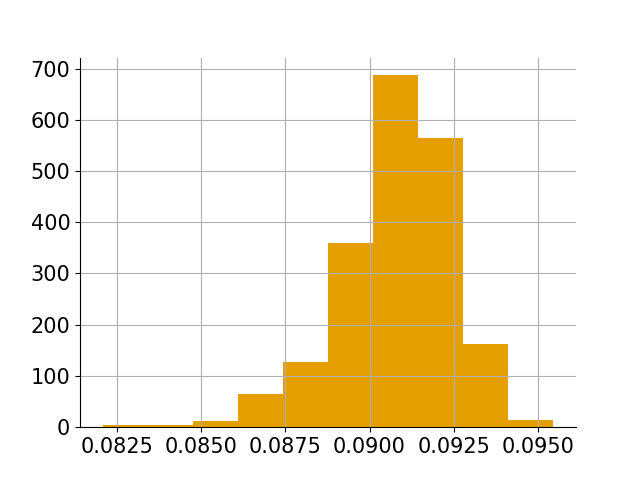

<AxesSubplot:>

In [15]:
fig, ax = plt.subplots()
pd.Series(samples_dict['beta']).hist(ax=ax)

<IPython.core.display.Javascript object>


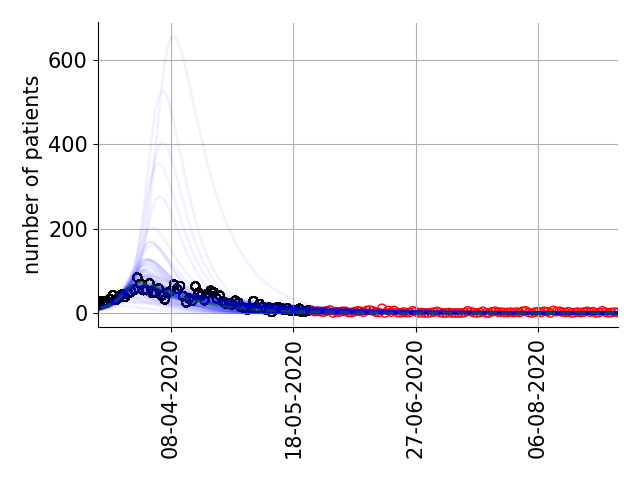

In [44]:
end_date = '2020-09-01'
plot_simulations(start_date, end_ramp, end_date, model_wave1, samples_dict, 
                timeseries, spatial_unit, n_lines=100, save=True)

# Step-by-step calibration

## Simulation until 1 July

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Hainaut_wave1_2020-11-03.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

In [ ]:
samples_dict = samples_dict_wave1

In [ ]:
fig, ax = plt.subplots()
pd.Series(samples_dict_wave1['beta']).hist(ax=ax)

In [ ]:
np.mean(samples_dict_wave1['beta'])

In [ ]:
samples_dict_wave1['lag_time']

In [ ]:
# Update this parameter here, the rest is updated by draw_sample_COVID19_SEIRD
model.parameters['policy_time'] = samples_dict_wave1['lag_time']

In [ ]:
out_july = model.sim(time='2020-07-01', excess_time=samples_dict_wave1['lag_time'],start_date='2020-03-15',
                   N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_july.isel(time=-1).mean(dim="draws")
initial_states_july1 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/prediction_provinces/Luik_initial_states_july1.npy', initial_states_july1)

## Calibration month July

In [ ]:
initial_states_july1 = np.load('../data/interim/prediction_provinces/Luik_initial_states_july1.npy', allow_pickle=True).item()

In [ ]:
# Second wave
start_date = '2020-07-01'
end_beta = '2020-08-01'

In [ ]:
len(Luik_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
#model_sept = models.COVID19_SEIRD(initial_states_sept, params)
model_july = models.COVID19_SEIRD(initial_states_july1, params)

In [ ]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_July'

In [ ]:
beta_init = np.mean(samples_dict_wave1['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])

In [ ]:
samples_dict = full_calibration_wave2(model_july, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None,None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total,steps_mcmc=1000)

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
states = [['H_in']]
end_date = end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(200):
    idx,model_july.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    y_model = model_july.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim(start_date, end_date)
ax.set_ylabel('daily hospitalizations')
fig.savefig(fig_path+spatial_unit+'.pdf',
            bbox_inches='tight', dpi=600)

## Simulation until 1 August

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_July_2020-10-30.json', 'r') as fp:
    samples_dict_july = json.load(fp)

In [ ]:
# Update this parameter here, the rest is updated by draw_sample_COVID19_SEIRD
# model.parameters['policy_time'] = samples_dict_wave1['lag_time']

In [ ]:
out_aug = model_july.sim(time='2020-08-01', excess_time=0,start_date='2020-07-01',
                   N=100, draw_fcn=draw_sample_beta_COVID19_SEIRD,samples=samples_dict_july)
states = out_aug.isel(time=-1).mean(dim="draws")
initial_states_aug1 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/prediction_provinces/Luik_initial_states_aug1.npy', initial_states_aug1)

## Calibration month August

In [ ]:
initial_states_aug1 = np.load('../data/interim/prediction_provinces/Luik_initial_states_aug1.npy', allow_pickle=True).item()

In [ ]:
# Second wave
start_date = '2020-08-01'
end_beta = '2020-09-01'

In [ ]:
len(Luik_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
#model_sept = models.COVID19_SEIRD(initial_states_sept, params)
model_aug = models.COVID19_SEIRD(initial_states_aug1, params)

In [ ]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_Aug'

In [ ]:
beta_init = np.mean(samples_dict_july['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])

In [ ]:
mu_beta, std_beta = norm.fit(samples_dict_july['beta'])
mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['sigma_data']) # should be on july!
beta_norm_params = (mu_beta, std_beta)
sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [ ]:
samples_dict = full_calibration_wave2(model_aug, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None, None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total,steps_mcmc=1000)

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
## Deze herrunnen!
states = [['H_in']]
end_date = end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(20):
    idx,model_aug.parameters['beta'] = random.choice(list(enumerate(samples_dict_aug['beta'])))
    y_model = model_aug.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim(start_date, end_date)
ax.set_ylabel('daily hospitalizations')
# fig.savefig(fig_path+spatial_unit+'.pdf',
#             bbox_inches='tight', dpi=600)

## Simulation until 1 September

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_Aug_2020-10-30.json', 'r') as fp:
    samples_dict_aug = json.load(fp)

In [ ]:
# Update this parameter here, the rest is updated by draw_sample_COVID19_SEIRD
# model.parameters['policy_time'] = samples_dict_wave1['lag_time']

In [ ]:
out_sept = model_aug.sim(time='2020-09-01', excess_time=0,start_date='2020-08-01',
                   N=100, draw_fcn=draw_sample_beta_COVID19_SEIRD,samples=samples_dict_aug)
states = out_sept.isel(time=-1).mean(dim="draws")
initial_states_sept1 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/prediction_provinces/Luik_initial_states_sept1.npy', initial_states_sept1)

In [ ]:
initial_states_sept1

## Calibration month September

In [ ]:
initial_states_sept1 = np.load('../data/interim/prediction_provinces/Luik_initial_states_sept1.npy', allow_pickle=True).item()

In [ ]:
# Second wave
start_date = '2020-09-01'
end_beta = '2020-10-01'

In [ ]:
len(Luik_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
#model_sept = models.COVID19_SEIRD(initial_states_sept, params)
model_sept = models.COVID19_SEIRD(initial_states_sept1, params)

In [ ]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_Sept'

In [ ]:
beta_init = 0.03
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])

In [ ]:
# mu_beta, std_beta = norm.fit(samples_dict_aug['beta'])
# mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['sigma_data']) # should be on aug!
# beta_norm_params = (mu_beta, std_beta)
# sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [ ]:
samples_dict = full_calibration_wave2(model_aug, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None, None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total,steps_mcmc=1000)

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
states = [['H_in']]
end_date = end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(20):
    idx,model_sept.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    y_model = model_sept.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim(start_date, end_date)
ax.set_ylabel('daily hospitalizations')
fig.savefig(fig_path+spatial_unit+'.pdf',
            bbox_inches='tight', dpi=600)

# Calibration on October

## Simulation until end September

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Hainaut_wave1_2020-11-03.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

In [ ]:
states = [['H_in']]
end_date = '2020-09-28'
data=[timeseries[start_date:end_ramp].values]

fig,ax=plt.subplots()
for i in range(20):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict_wave1['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict_wave1['l'])))
    model.parameters['tau'] = samples_dict_wave1['tau'][idx]
    model.parameters['policy_time'] = samples_dict_wave1['warmup']
    model.parameters['prevention'] = samples_dict_wave1['prevention'][idx]
    y_model = model.sim(time=end_date, excess_time=samples_dict_wave1['warmup'], start_date=start_date)
    ax = plot_fit(y_model,data,start_date,samples_dict_wave1['warmup'],states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim('2020-03-10', end_date)

In [ ]:
out_sept28 = model.sim(time='2020-09-28', excess_time=samples_dict_wave1['warmup'],start_date='2020-03-15',
                   N=10, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_sept28.isel(time=-1).mean(dim="draws")
initial_states_sept28 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
out_sept28.isel(time=-1).mean(dim="draws")

In [ ]:
np.save('../data/interim/prediction_provinces/Hainaut_initial_states_Sept28.npy', initial_states_sept28)

## Calibration starting September 28

In [ ]:
initial_states_sept28 = np.load('../data/interim/prediction_provinces/Hainaut_initial_states_Sept28.npy', allow_pickle=True).item()

In [ ]:
initial_states_sept28

In [ ]:
# Second wave
start_date = '2020-09-28'
end_beta = '2020-10-30'

In [ ]:
len(Hainaut_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
model = models.COVID19_SEIRD(initial_states_sept28, params)

In [ ]:
# function parameters 
timeseries = Hainaut_ts['NEW_IN']
spatial_unit = 'Hainaut_wave2_from_sept28'


In [ ]:
# mu_beta, std_beta = norm.fit(samples_dict_wave1['beta'])
# mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['beta'])
# beta_norm_params = (mu_beta, std_beta)
# sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [ ]:
beta_init = np.mean(samples_dict_wave1['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])


In [ ]:
samples_dict = full_calibration_wave2(model, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None, None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total, 
                                      maxiter=100, popsize=200, steps_mcmc=1000)

In [ ]:
fig, ax = plt.subplots()
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
states = [['H_in']]
end_date = '2021-01-01' #end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(20):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    y_model = model.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim('2020-09-01', '2021-01-01')
ax.set_ylabel('daily hospitalizations')
# fig.savefig(fig_path+spatial_unit+'.pdf',
#             bbox_inches='tight', dpi=600)

In [ ]:
fig.savefig(fig_path+spatial_unit+'.pdf',
            bbox_inches='tight', dpi=600)

# Calibration from August 1

In [49]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Hainaut_wave1_2020-11-04.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

## Simulation until August 1 with policies

In [ ]:
out_aug1 = model_wave1_with_policies.sim(time='2020-08-01', excess_time=samples_dict_wave1['warmup'],start_date='2020-03-15',
                   N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_aug1.isel(time=-1).mean(dim="draws")
initial_states_aug1 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/prediction_provinces/Hainaut_initial_states_Aug1.npy', initial_states_aug1)

## Simulation until August 1 without policies

In [51]:
out_aug1 = model_wave1.sim(time='2020-08-01', excess_time=samples_dict_wave1['warmup'],start_date='2020-03-15',
                   N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_aug1.isel(time=-1).mean(dim="draws")
initial_states_aug1 = {key:states[key].values for key in initial_states.keys()}

In [53]:
np.save('../data/interim/initial_states_provinces/'+spatial_unit+'_Aug1.npy', initial_states_aug1)

## Calibration starting August 1

In [55]:
initial_states_aug1 = np.load('../data/interim/initial_states_provinces/Hainaut_wave1_Aug1.npy', allow_pickle=True).item()

In [56]:
# Second wave
start_date = '2020-08-01'
end_beta = '2020-10-26'

In [57]:
len(Hainaut_ts.loc[start_date:end_beta])

87

In [58]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
model_wave2_from_aug1 = models.COVID19_SEIRD(initial_states_aug1, params)

In [ ]:
# mu_beta, std_beta = norm.fit(samples_dict_wave1['beta'])
# mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['beta'])
# beta_norm_params = (mu_beta, std_beta)
# sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [59]:
beta_init = np.mean(samples_dict_wave1['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])


In [61]:
spatial_unit = 'Hainaut_wave2_from_aug1_no_policies'
samples_dict = full_calibration_wave2(model_wave2_from_aug1, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None, None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total, pso=False,
                                      maxiter=100, popsize=200, steps_mcmc=1000)

100%|██████████| 1000/1000 [05:47<00:00,  2.88it/s]


Calibrating beta. Warning: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!


<IPython.core.display.Javascript object>


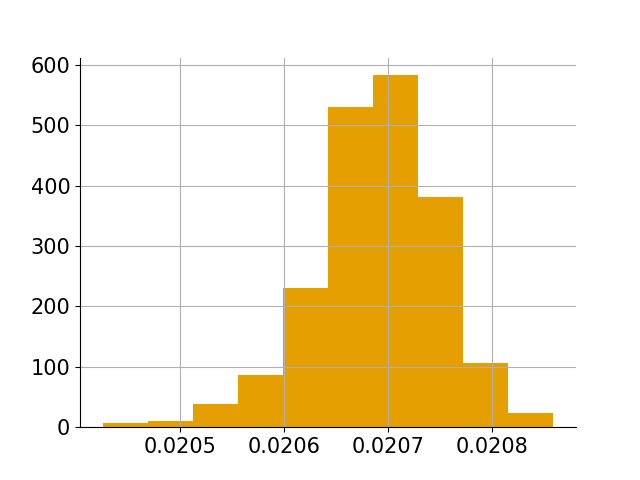

<AxesSubplot:>

In [62]:
fig, ax = plt.subplots()
pd.Series(samples_dict['beta']).hist(ax=ax)

In [74]:
end_date = '2021-01-01'
plot_simulations(start_date, end_ramp, end_date, model_wave2_from_aug1, samples_dict, 
                timeseries, spatial_unit, n_lines=200, save=True)